In [1]:
import copy
import random
import numpy as np
import math
import openpyxl
from collections import defaultdict
import random
import matplotlib.pyplot as plt
import time

In [2]:
class Node:
    def __init__(self, state, parent=None):
        self.state = state
        self.parent = parent
        self.children = []
        self.visits = 0
        self.value = 0

    def add_child(self, child):
        self.children.append(child)

    def update(self, value):
        self.visits += 1
        self.value += value

    def ucb1(self, total_visits):
        return self.value / self.visits + math.sqrt(2 * math.log(total_visits) / self.visits)

In [3]:
class MCTS:
    def __init__(self, game, num_simulations):
        self.game = game
        self.num_simulations = num_simulations

    def search(self, root_state):
        root = Node(root_state)

        for _ in range(self.num_simulations):
            node = self.select(root)
            result = self.simulate(node.state)
            self.backpropagate(node, result)

        return self.best_child(root)

    def select(self, node):
        while not self.game.is_terminal(node.state):
            if not self.game.is_fully_expanded(node):
                return self.expand(node)
            else:
                node =  self.best_child(node)
        return node

    def expand(self, node):
        state = self.game.random_unexpanded_child(node)
        child = Node(state, parent=node)
        node.add_child(child)
        return child

    def simulate(self, state):
        while not self.game.is_terminal(state):
            state = self.game.random_child(state)
        return self.game.reward(state)

    def backpropagate(self, node, result):
        while node is not None:
            node.update(result)
            result = -result
            node = node.parent

    def best_child(self, node):
        total_visits = sum(child.visits for child in node.children)
        return max(node.children, key=lambda child: child.ucb1(total_visits))

In [4]:
class SOR:
    def __init__(self, items, capacity, side):
        self.items = items
        self.capacity = capacity
        self.side = side

    def is_terminal(self, state):
        remaining_capacity, remaining_items, dropped_items = state
        return remaining_capacity <= 0 or len(remaining_items) == 0

    def is_fully_expanded(self, node):
        return len(node.state[1]) == len(node.children)

    def random_child(self, state):
        remaining_capacity, remaining_items, dropped_items = state
        item = random.choice(remaining_items)
        new_remaining_items = remaining_items.copy()
        new_remaining_items.remove(item)
        new_dropped_items = dropped_items.copy()
        if item[2] <= remaining_capacity:
            new_remaining_capacity = remaining_capacity - item[2]
            return new_remaining_capacity, new_remaining_items, new_dropped_items
        else:
            new_dropped_items.append(item)
            return remaining_capacity, new_remaining_items, new_dropped_items

    def random_unexpanded_child(self, node):
        remaining_capacity, remaining_items, dropped_items = node.state
        expanded_items = []
        for child in node.children:
            expanded_item = [item for item in remaining_items if item not in set(child.state[1])]
            expanded_items = list(set(expanded_items)&set(expanded_item))
        unexpanded_items = list(set(remaining_items)-set(expanded_items))
        item = random.choice(unexpanded_items)
        new_remaining_items = remaining_items.copy()
        new_remaining_items.remove(item)
        new_dropped_items = dropped_items.copy()
        if item[2] <= remaining_capacity:
            new_remaining_capacity = remaining_capacity - item[2]
            return new_remaining_capacity, new_remaining_items, new_dropped_items
        else:
            new_dropped_items.append(item)
            return remaining_capacity, new_remaining_items, new_dropped_items

    def reward(self, state):
        remaining_capacity, remaining_items, dropped_items = state
        if self.side == 'buy':
            return sum(item[1] for item in self.items) - sum(item[1] for item in remaining_items)
        else:
            return sum(item[1] for item in remaining_items) - sum(item[1] for item in self.items)
    

In [5]:
items = [('BATS', 10 ,2), ('BATS', 7 ,7), ('BATS', 5 ,3), ('BATS', 10 ,4), ('BATS', 12 ,4)]
capacity = 14
side = 'buy'
sor = SOR(items, capacity, side)
mcts = MCTS(sor, num_simulations=1000)
root_state = (capacity, items, [])
best_state = mcts.search(root_state)
solution = best_state
while not len(solution.children)==0:
    solution =mcts.best_child(solution)
packed_items = [item for item in items if ((item not in solution.state[1]) and (item not in solution.state[2]))]
print(packed_items)

[('BATS', 7, 7), ('BATS', 5, 3), ('BATS', 12, 4)]


In [6]:
orders_file = 'data/orders.xlsx'
workbook = openpyxl.load_workbook(orders_file)

In [7]:
sheetnames= workbook.get_sheet_names()
print(sheetnames)

['Microsofts', 'Netflix']


C:\Users\Thumbby\AppData\Local\Temp\ipykernel_10028\2214667223.py:1: DeprecationWarning: Call to deprecated function get_sheet_names (Use wb.sheetnames).
  sheetnames= workbook.get_sheet_names()


In [8]:
sheetMSFT = workbook.worksheets[0]
sheetNFLX = workbook.worksheets[1]
sheetMSFTNAME = sheetMSFT.title
sheetNFLXNAME = sheetNFLX.title
print(sheetMSFTNAME)
print(sheetNFLXNAME)

Microsofts
Netflix


In [9]:
# Get the dictionary of price-to-qunatity
excelbids = defaultdict(list)
excelasks = defaultdict(list)
for i in range(3, 8):
	for j in range(1, 2):
		excelbids[sheetMSFTNAME].append(('NASD',sheetMSFT.cell(i, j).value,sheetMSFT.cell(i, j+1).value))
	for j in range(3, 4):
		excelasks[sheetMSFTNAME].append(('NASD',sheetMSFT.cell(i, j).value,sheetMSFT.cell(i, j+1).value))

for i in range (10, 15):
	for j in range(1, 2):
		excelbids[sheetMSFTNAME].append(('BATS',sheetMSFT.cell(i, j).value,sheetMSFT.cell(i, j+1).value))
	for j in range(3, 4):
		excelasks[sheetMSFTNAME].append(('BATS',sheetMSFT.cell(i, j).value,sheetMSFT.cell(i, j+1).value))

for i in range(3, 8):
	for j in range(1, 2):
		excelbids[sheetNFLXNAME].append(('NASD',sheetMSFT.cell(i, j).value,sheetMSFT.cell(i, j+1).value))
	for j in range(3, 4):
		excelasks[sheetNFLXNAME].append(('NASD',sheetMSFT.cell(i, j).value,sheetMSFT.cell(i, j+1).value))

for i in range (10, 15):
	for j in range(1, 2):
		excelbids[sheetNFLXNAME].append(('BATS',sheetMSFT.cell(i, j).value,sheetMSFT.cell(i, j+1).value))
	for j in range(3, 4):
		excelasks[sheetNFLXNAME].append(('BATS',sheetMSFT.cell(i, j).value,sheetMSFT.cell(i, j+1).value))
		
print(excelbids)
print(excelasks)

defaultdict(<class 'list'>, {'Microsofts': [('NASD', 183.65, 500), ('NASD', 183.64, 200), ('NASD', 183.63, 500), ('NASD', 183.92, 1450), ('NASD', 183.81, 1000), ('BATS', 183.65, 30), ('BATS', 183.64, 450), ('BATS', 183.73, 175), ('BATS', 183.62, 400), ('BATS', 183.71, 1050)], 'Netflix': [('NASD', 183.65, 500), ('NASD', 183.64, 200), ('NASD', 183.63, 500), ('NASD', 183.92, 1450), ('NASD', 183.81, 1000), ('BATS', 183.65, 30), ('BATS', 183.64, 450), ('BATS', 183.73, 175), ('BATS', 183.62, 400), ('BATS', 183.71, 1050)]})
defaultdict(<class 'list'>, {'Microsofts': [('NASD', 183.91, 100), ('NASD', 183.97, 300), ('NASD', 183.93, 1075), ('NASD', 183.94, 800), ('NASD', 183.85, 200), ('BATS', 183.91, 500), ('BATS', 183.94, 400), ('BATS', 183.95, 1125), ('BATS', 183.96, 675), ('BATS', 183.78, 180)], 'Netflix': [('NASD', 183.91, 100), ('NASD', 183.97, 300), ('NASD', 183.93, 1075), ('NASD', 183.94, 800), ('NASD', 183.85, 200), ('BATS', 183.91, 500), ('BATS', 183.94, 400), ('BATS', 183.95, 1125), ('

In [10]:
def mcts_smart_order_router(side, symbol, qty, order_type='market', price = None):
    needed_qty = qty
    route = {}
    available_qty = 0
    if side == 'buy':
        bid_shared = []
        for shared in excelbids[symbol]:
            if order_type == 'limit' and shared[1] <= price:
                bid_shared.append(shared)
        if len(bid_shared) == 0:
            return 'No available shared'
        sor = SOR(bid_shared, needed_qty, side)
        mcts = MCTS(sor, num_simulations=1000)
        root_state = (needed_qty, bid_shared, [])
        best_state = mcts.search(root_state)
        solution = best_state
        while not len(solution.children)==0:
            solution =mcts.best_child(solution)
        packed_items = [item for item in bid_shared if ((item not in solution.state[1]) and (item not in solution.state[2]))]
        for packed_item in packed_items:
            exchanger = packed_item[0]
            if exchanger not in route:
                route[exchanger] = {}
            route[exchanger][packed_item[1]] = packed_item[2]
            available_qty = available_qty + packed_item[2]
        order = {'route':route, 'leave_qty': needed_qty - available_qty}
    elif side == 'sell':
        ask_shared = []
        for shared in excelasks[symbol]:
            if order_type == 'limit' and shared[1] >= price:
                ask_shared.append(shared)
        if len(ask_shared) == 0:
            return 'No available shared'
        sor = SOR(ask_shared, needed_qty, side)
        mcts = MCTS(sor, num_simulations=1000)
        root_state = (needed_qty, ask_shared, [])
        best_state = mcts.search(root_state)
        solution = best_state
        while not len(solution.children)==0:
            solution =mcts.best_child(solution)
        packed_items = [item for item in ask_shared if ((item not in solution.state[1]) and (item not in solution.state[2]))]
        for packed_item in packed_items:
            exchanger = packed_item[0]
            if exchanger not in route:
                route[exchanger] = {}
            route[exchanger][packed_item[1]] = packed_item[2]
            available_qty = available_qty + packed_item[2]
        order = {'route':route, 'leave_qty': needed_qty - available_qty}
    return order

In [33]:
qty = random.randint(500, 1000)
limit_price = round(random.uniform(180, 190), 2)
order = mcts_smart_order_router('buy', 'Microsofts', qty, 'limit', limit_price)
print(f'This investor want to buy {qty} shared at {limit_price} price')
print(order)

This investor want to buy 777 shared at 188.2 price
{'route': {'NASD': {183.64: 200}, 'BATS': {183.65: 30, 183.64: 450}}, 'leave_qty': 97}


In [25]:
qty = random.randint(500, 1000)
limit_price = round(random.uniform(180, 190), 2)
order = mcts_smart_order_router('sell', 'Microsofts', qty, 'limit', limit_price)
print(f'This investor want to sell {qty} shared at {limit_price} price')
print(order)

This investor want to sell 645 shared at 181.07 price
{'route': {'NASD': {183.85: 200}, 'BATS': {183.94: 400}}, 'leave_qty': 45}


In [49]:
# buy test
buy_times = []
buy_counts = []
step = 0
for i in range(100, 1000, 100):
    print(i)
    start_time = time.time()
    for order_count in range(0, i):
        qty = random.randint(1000, 5000)
        limit_price = round(random.uniform(183.5, 184.5), 2)
        route = mcts_smart_order_router('buy', 'Microsofts', qty, 'limit', limit_price)
        '''print(f'This investor want to buy {qty} shared at {limit_price} price')
        print(route)'''
    end_time = time.time()
    buy_times.append(end_time - start_time)
    buy_counts.append(i)

100
200
300
400
500
600
700
800
900


In [50]:
# sell test
sell_times = []
sell_counts = []
step = 0
for i in range(100, 1000, 100):
    print(i)
    start_time = time.time()
    for order_count in range(0, i):
        qty = random.randint(1000, 5000)
        limit_price = round(random.uniform(183.5, 184.5), 2)
        route = mcts_smart_order_router('sell', 'Microsofts', qty, 'limit', limit_price)
        '''print(f'This investor want to sell {qty} shared at {limit_price} price')
        print(route)'''
    end_time = time.time()
    sell_times.append(end_time - start_time)
    sell_counts.append(i)

100
200
300
400
500
600
700
800
900


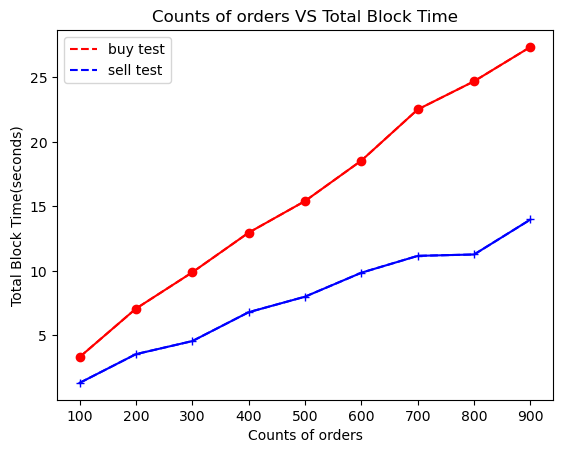

In [51]:
buy_line = plt.plot(buy_counts, buy_times, 'r--', label = 'buy test')
sell_line = plt.plot(sell_counts, sell_times, 'b--', label = 'sell test')
plt.plot(buy_counts, buy_times, 'ro-', sell_counts, sell_times, 'b+-')
plt.title('Counts of orders VS Total Block Time')
plt.xlabel('Counts of orders')
plt.ylabel('Total Block Time(seconds)')
plt.legend()
plt.show()